![CF](imgs/netflixCF.png)

# Collaborative Filtering using Deep Learning

In this notebook, we will use a Deep Learning / Neural Network approach that is up and coming with recent development in machine learning and AI technologies.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import keras
from wordcloud import WordCloud
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


## Data Loading

In [4]:
# Reading rating file
dataset = pd.read_csv("ratings.zip", compression='zip', sep='::',
                 names=['real_user_id','real_movie_id','rating','timestamp'], header=None, usecols=['real_user_id','real_movie_id','rating'])
#Convert user and movie ids from int to categories
dataset['user_id'] = dataset['real_user_id'].astype('category').cat.codes.values
dataset['movie_id'] = dataset['real_movie_id'].astype('category').cat.codes.values
print(dataset.shape)

(1000209, 5)


In [5]:
# Reading movies file
movies = pd.read_csv('ml-1m/movies.dat', sep='::', encoding='latin-1', 
                     names=['movie_id', 'title', 'genres'], header=None)
movies.shape

(3883, 3)

In [6]:
train, test = train_test_split(dataset, test_size=0.2)

## Building Model

The idea of using deep learning is similar to that of Model-Based Matrix Factorization. In matrix factorization, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For deep learning implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

Here are the main components of my neural network:

- A left embedding layer that creates a Users by Latent Factors matrix.
- A right embedding layer that creates a Movies by Latent Factors matrix.
- When the input to these layers are (i) a user id and (ii) a movie id, they’ll return the latent factor vectors for the user and the movie, respectively.
- A merge layer that takes the dot product of these two latent vectors to return the predicted rating.


I then compile the model using Mean Squared Error (MSE) as the loss function and the AdaMax learning algorithm.

In [7]:
def buildNN(n_users, n_movies, n_latent_factors):
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

    prod = keras.layers.dot([movie_vec, user_vec], axes= 1, name='DotProduct')
    model = keras.Model([user_input, movie_input], prod)
    # model.compile('adam', 'mean_squared_error')
    model.compile(loss='mse', optimizer='adamax')
    return model

In [8]:
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.movie_id.unique())
n_latent_factors = 500

model=buildNN(n_users, n_movies, n_latent_factors)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 500)       1853500     Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 500)       3020500     User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

   ### Layers Architecture 
![NN arch](imgs/embedding-layers.png)

### Training Model

In [9]:
# Callbacks monitor the validation loss# Callb 
# Save the model weights each time the validation loss has improved
# callbacks = [EarlyStopping('val_loss', patience=2), 
#            ModelCheckpoint('weights.h5', save_best_only=True)]


# history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10, validation_split=0.2, verbose=2, callbacks=callbacks)

# Show the best validation MAE
# min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
# print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(abs(min_val_loss)))

# pd.Series(history.history['loss']).plot(logy=True)
# plt.xlabel("Epoch")
# plt.ylabel("Train Error")

In [10]:
model.load_weights('weights.h5')
y_hat = np.round(model.predict([test.user_id, test.movie_id]), 0)
y_true = test.rating # discrete values from 1 to 5

In [11]:
#see the first 10 entries
for i, j in zip(y_hat[:10], y_true[:10]):
    print("Predicted:", i[0], "\tTrue:", j)

Predicted: 2.0 	True: 2
Predicted: 2.0 	True: 2
Predicted: 5.0 	True: 5
Predicted: 4.0 	True: 4
Predicted: 4.0 	True: 5
Predicted: 4.0 	True: 4
Predicted: 3.0 	True: 3
Predicted: 4.0 	True: 4
Predicted: 3.0 	True: 3
Predicted: 4.0 	True: 4


In [12]:
# mean_absolute_error(y_true[0:10], y_hat[0:10])
mean_absolute_error(y_true, y_hat)

0.49612581357914837

In [13]:
#helper functions
def get_movie_ids(userID, rating):
    """
    This method takes a user id and rating and returns
    data frame contains only the movies ids that the 
    user has watched and rated the given rating
    """
    real_user_id = dataset.loc[(dataset['user_id'] == userID)]['real_user_id'].iloc[0]
    df = dataset.loc[(dataset['real_user_id'] == real_user_id)]
    return list(df[dataset['rating']== rating]['real_movie_id'])

def get_movies_genres(movie_ids):
    """
    This method takes a list of movie ids and return their
    genres combines in a one str
    """
    genres = []
    for movie_id in movie_ids:
        genres.extend(list(movies[movies['movie_id']==movie_id]['genres'])[0].split('|'))
    return ' '.join(genres)


In [18]:
def recommend_movies(userID):
    #----- wordcloud of user movies -----
    user_genres = get_movies_genres(get_movie_ids(userID, rating=5))
    wordcloud = WordCloud().generate(user_genres)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("watched movies genres")
    plt.show()
    #------------------------------------
    
    #preparing recommendations
    predictedRatingsDF=pd.DataFrame(columns=['movie_id','rating'])
    for movie_id in list(set(dataset.movie_id)):
        predictedRating = model.predict([np.array([userID]),np.array([movie_id])])[0][0]
        real_movie_id = dataset.loc[(dataset['movie_id'] == movie_id)]['real_movie_id'].iloc[0]
        predictedRatingsDF.loc[predictedRatingsDF.shape[0]]=pd.Series({"movie_id":real_movie_id,
                                                                       "rating":predictedRating})
    df = predictedRatingsDF.sort_values(by=['rating'], ascending=False).reset_index(drop=True)[:20]
    
    
    #----- wordcloud of recommended movies -----
    text = get_movies_genres(list(df['movie_id']))
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("recommended movies genres")
    plt.show()
    #-------------------------------------------
    return df

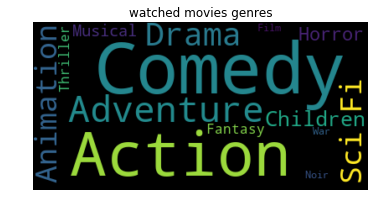

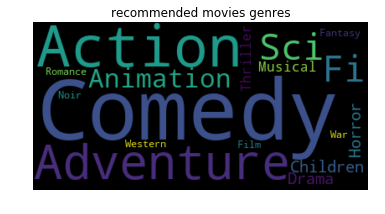

,movie_id,rating
0,2791.0,4.994636
1,1198.0,4.797114
2,919.0,4.734626
3,260.0,4.731014
4,1196.0,4.702335
5,1.0,4.614853
6,1136.0,4.578426
7,1291.0,4.578344
8,2987.0,4.530724
9,3671.0,4.523731


In [19]:
recommend_movies(userID = 2222)